In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, Dense, Input, Flatten, Dropout, MaxPooling2D, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Model
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import pickle
import numpy as np
from PIL import Image
%matplotlib inline

In [ ]:
!git clone -l -s https://github.com/monacotime/DeepForSpeed.git DeepForSpeed

Cloning into 'DeepForSpeed'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 2103 (delta 4), reused 12 (delta 3), pack-reused 2089
Receiving objects: 100% (2103/2103), 1.82 GiB | 43.19 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (2011/2011), done.


**class_mode:** One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned: - "categorical" will be 2D one-hot encoded labels, - "binary" will be 1D binary labels, "sparse" will be 1D integer labels, - "input" will be images identical to input images (mainly used to work with autoencoders). - If ***`None`***, ***no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict_generator()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly.***

`This block is not true but im keeping it as a reminder`


> What happens is that if class = none, all the images are mixed and no class data is there but if the class mode is categorical the all data are still mixed and jumbled but the class data is there so regardless you cant index the two types of related images from 2 different direcotory together. that is why you have got to make 2 generaters and they will give out output in a sequence which can be later mixed to make the final related input.

You done need to structure it like how I did:
## I now realize that flowfromdir(class = None) 

[0][0] -> first class first image (no class data)

[1][0] -> second class first image (no class data)

In [ ]:
batch_size = 8
dataset_dir = r"/content/DeepForSpeed/Dataset"
img_height,img_width = 500,500
input_shape = (500, 1000, 1)
with open(r"/content/DeepForSpeed/Dataset/train/speed.txt", "rb") as fp:
    speed = pickle.load(fp)
# dist = [round((i*1000)/(60*60*4),5) for i in speed]
# dist_data = tf.data.Dataset.from_tensor_slices(dist)

In [ ]:
def dataset_maker(dataset, subset = "train"):
    before_images =  np.array([np.array(Image.open(f"{dataset}/{subset}/Before/{fname}.png").
                                   convert('L').
                                   resize((img_width,img_height)
                                   )) for fname in range(0,1000)])
    
    after_images = np.array([np.array(Image.open(f"{dataset}/{subset}/After/{fname}.png").
                                  convert('L').
                                  resize((img_width,img_height)
                                  )) for fname in range(0,1000)])
    return np.concatenate((before_images, after_images), axis = 2)

In [ ]:
dataset = np.expand_dims(dataset_maker(dataset_dir,"train"), -1)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    rescale=1./255
)
traingen = datagen.flow(
    dataset,
    y=speed,
    batch_size=batch_size,
    shuffle=True,
    seed=100,
)


In [ ]:
input = Input(shape = input_shape, name='input_1')
model = Conv2D(64, (3, 3), input_shape = input_shape, padding='same')(input)
model = LeakyReLU(alpha=0.1)(model)
model = MaxPooling2D((2, 2))(model)
# model = Dropout(0.1)(model)

model = Conv2D(32, (3, 3))(model)
model = LeakyReLU(alpha=0.1)(model)
model = MaxPooling2D((2, 2))(model)
# model = Dropout(0.2)(model)

model = Conv2D(16, (3, 3))(model)
model = LeakyReLU(alpha=0.1)(model)
model = MaxPooling2D((2, 2))(model)
# model = Dropout(0.25)(model)

model = Conv2D(8, (3, 3))(model)
model = LeakyReLU(alpha=0.1)(model)
model = MaxPooling2D((2, 2))(model)
# model = Dropout(0.25)(model)

model = Flatten()(model)
model = Dense(32)(model)
model = LeakyReLU(alpha=0.1)(model)
# model = Dropout(0.2)(model)

model = Dense(16)(model)
model = LeakyReLU(alpha=0.1)(model)
# model = Dropout(0.2)(model)

output = Dense(1)(model)

model = Model(inputs = [input], outputs = [output])

opt = optimizers.Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(optimizer= opt,
              loss="mean_squared_error")
# model.summary()

In [ ]:
class new_callback(tf.keras.callbacks.Callback):
    def epoch_end(self, epoch, logs={}): 
        if(logs.get('loss')< 0.1): # select the accuracy
            print("\n !!! 90% accuracy, no further training !!!")
            self.model.stop_training = True

callbacks = new_callback()

In [ ]:
history = model.fit(traingen, 
                    steps_per_epoch=100, 
                    epochs = 120, 
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks= callbacks)

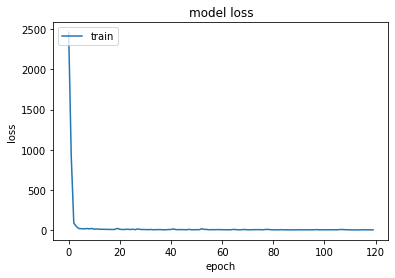

In [ ]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("DeepForSpeed_model.h5")

In [ ]:
res = model.predict(meat[0])

In [ ]:
check = iter(traingen)
meat = next(check)
meat[1]

array([ 22, 117,  57,  70, 147, 122,  64, 120])

In [ ]:
print(res)

[[ 22.343164]
 [115.45918 ]
 [ 56.98182 ]
 [ 69.07182 ]
 [143.32303 ]
 [120.60254 ]
 [ 62.98358 ]
 [116.622116]]


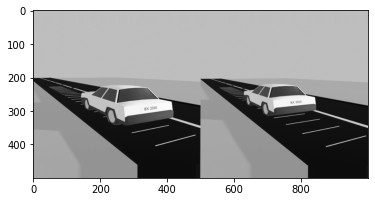

In [ ]:
imshow(meat[0][0].squeeze(), cmap = "gray")